Making this reference mostly for myself - hope others find these tricks useful

## Table of Contents

- [Imports](#imports)
- [Theming](#theming)
    - [Colorblind testing](#colorblind-testing)
    - [Categorical Colors](#categorical-colors)
    - [Continuous and Divergent Colormaps](#continuous-and-divergent-colormaps)
- [Figure sizing](#figure-sizing)
    - [Figure padding](#figure-padding)
- [Gridspec](#gridspec)
    - [Nested gridspecs](#nested-gridspecs)
- [Scatterplots](#scatterplots)
    - [Density scatterplots](#density-scatterplots)
        - [Fast subsampled density kernels](#fast-subsampled-density-kernels)
        - [Stored density kernels](#stored-density-kernels)
    - [Scatterplot rasterization](#scatterplot-rasterization)
- [Text annotation](#text-annotation)
    - [Blended transforms](#blended-transforms)
    - [Point annotation](#point-annotation)
- [Grids](#grids)
- [Colorbars](#colorbars)

### Imports

In [3]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## Theming

[Matplotlib rcParams reference](https://matplotlib.org/stable/tutorials/introductory/customizing.html)

Most of the seaborn defaults are sensible, so I just build around them with `sns.set`

For figures, I go with a default font size of 9 pt and a line size of 0.5 pt. Smaller fonts and thinner lines will be harder to read on print, but for super compact figures I sometimes go down to 7 pt font.

For theme colors, I follow *Never Use Black*: [https://ianstormtaylor.com/design-tip-never-use-black/](https://ianstormtaylor.com/design-tip-never-use-black/)

In [275]:
_new_black = '#373737'
sns.set_theme(style='ticks', font_scale=0.75, rc={
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans'],
    'svg.fonttype': 'none',
    'text.usetex': False,
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.size': 9,
    'axes.labelsize': 9,
    'axes.titlesize': 9,
    'axes.labelpad': 2,
    'axes.linewidth': 0.5,
    'axes.titlepad': 4,
    'lines.linewidth': 0.5,
    'legend.fontsize': 9,
    'legend.title_fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'xtick.major.size': 2,
    'xtick.major.pad': 1,
    'xtick.major.width': 0.5,
    'ytick.major.size': 2,
    'ytick.major.pad': 1,
    'ytick.major.width': 0.5,
    'xtick.minor.size': 2,
    'xtick.minor.pad': 1,
    'xtick.minor.width': 0.5,
    'ytick.minor.size': 2,
    'ytick.minor.pad': 1,
    'ytick.minor.width': 0.5,

    # Avoid black unless necessary
    'text.color': _new_black,
    'patch.edgecolor': _new_black,
    'patch.force_edgecolor': False, # Seaborn turns on edgecolors for histograms by default and I don't like it
    'hatch.color': _new_black,
    'axes.edgecolor': _new_black,
    # 'axes.titlecolor': _new_black # should fallback to text.color
    'axes.labelcolor': _new_black,
    'xtick.color': _new_black,
    'ytick.color': _new_black

    # Default colormap - personal preference
    # 'image.cmap': 'inferno'
})

### Colorblind testing

For figure development, try Color Oracle [https://colororacle.org/](https://colororacle.org/), which simulates multiple different colorblindnesses and also grayscale. Ideally you should design your figure colors to also work in grayscale but in practice it's quite difficult with more than 2 categories.

If you're polishing figures in Illustrator, they also have colorblindness modes, in View -> Proof Setup -> Colorblindness

### Categorical Colors

I use [Paul Tol's Colorblind-friendly colors](http://web.archive.org/web/20211011090208/https://personal.sron.nl/~pault/) for all categorical mappings. Full python code is [here](http://personal.sron.nl/~pault/data/tol_colors.py).

In [1]:
def tol_cset(colorset=None):
    """
    Discrete color sets for qualitative data.

    Define a namedtuple instance with the colors.
    Examples for: cset = tol_cset(<scheme>)
      - cset.red and cset[1] give the same color (in default 'bright' colorset)
      - cset._fields gives a tuple with all color names
      - list(cset) gives a list with all colors
    """
    from collections import namedtuple
    
    namelist = ('bright', 'high-contrast', 'vibrant', 'muted', 'medium-contrast', 'light')
    if colorset == None:
        return namelist
    if colorset not in namelist:
        colorset = 'bright'
        print('*** Warning: requested colorset not defined,',
              'known colorsets are {}.'.format(namelist),
              'Using {}.'.format(colorset)) 

    if colorset == 'bright':
        cset = namedtuple('Bcset',
                    'blue red green yellow cyan purple grey black')
        return cset('#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE',
                    '#AA3377', '#BBBBBB', '#000000')

    if colorset == 'high-contrast':
        cset = namedtuple('Hcset',
                    'blue yellow red black')
        return cset('#004488', '#DDAA33', '#BB5566', '#000000')

    if colorset == 'vibrant':
        cset = namedtuple('Vcset',
                    'orange blue cyan magenta red teal grey black')
        return cset('#EE7733', '#0077BB', '#33BBEE', '#EE3377', '#CC3311',
                    '#009988', '#BBBBBB', '#000000')

    if colorset == 'muted':
        cset = namedtuple('Mcset',
                    'rose indigo sand green cyan wine teal olive purple pale_grey black')
        return cset('#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE',
                    '#882255', '#44AA99', '#999933', '#AA4499', '#DDDDDD',
                    '#000000')

    if colorset == 'medium-contrast':
        cset = namedtuple('Mcset',
                    'light_blue dark_blue light_yellow dark_red dark_yellow light_red black')
        return cset('#6699CC', '#004488', '#EECC66', '#994455', '#997700',
                    '#EE99AA', '#000000')

    if colorset == 'light':
        cset = namedtuple('Lcset',
                    'light_blue orange light_yellow pink light_cyan mint pear olive pale_grey black')
        return cset('#77AADD', '#EE8866', '#EEDD88', '#FFAABB', '#99DDFF',
                    '#44BB99', '#BBCC33', '#AAAA00', '#DDDDDD', '#000000')

### Continuous and Divergent Colormaps

Matplotlib's base guide on colormaps is quite good: [https://matplotlib.org/stable/tutorials/colors/colormaps.html](https://matplotlib.org/stable/tutorials/colors/colormaps.html)

**For continuous colormaps, always stick to "Perceptually Uniform Sequential Colormaps"**, as these colormaps convert nicely to grayscale and therefore to colorblindness as well. For a visual demonstration, see: [https://matplotlib.org/stable/tutorials/colors/colormaps.html#grayscale-conversion](https://matplotlib.org/stable/tutorials/colors/colormaps.html#grayscale-conversion).

For divergent colormaps, since it's impossible to differentiate high/low on grayscale, I usually use `coolwarm` over `bwr`, since the white tends to distract by blending into figure backgrounds (usually also white). 

Just my opinion, but I would stay away from divergent colormaps with black as the middle color (you still might see this being used in some RNA-seq papers, with the green-black-pink] colormap). They strike me as super overwhelming and more difficult to interpret than the middle-white colormaps.

I use the `matplotlib.cm` module to reference named colormaps directly:

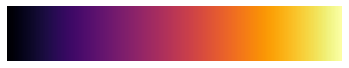

In [8]:
cmap = mpl.cm.inferno

fig, ax = plt.subplots(figsize=(6, 1))
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
ax.imshow(gradient, aspect='auto', cmap=cmap)
ax.set_axis_off()
plt.show()

You can get the reversed version of any colormap in `matplotlib` by appending `_r` to the colormap name

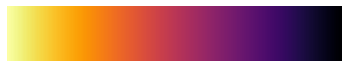

In [10]:
cmap = mpl.cm.inferno_r # Added _r to reverse colormap

fig, ax = plt.subplots(figsize=(6, 1))
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
ax.imshow(gradient, aspect='auto', cmap=cmap)
ax.set_axis_off()
plt.show()

## Figure sizing

I like to create my figures in the exact size that they will appear on paper/in print, so that I can get a good idea of what elements I can fit and how the font sizes/line sizes will look.

It's always hard to know exactly what your panel sizes for each plot will be inside of a figure, so I like to, if possible, block the figure out in Illustrator and use the rulers to estimate how big each panel will be.

If I don't know your panel sizes ahead of time, then I follow these general rules:
- For standard letter size (8.5 in x 11 in), your figures/panels should not exceed 6 inches
- For standard letter size, your whole figure shouldn't be taller than 8 inches. This leaves room for a figure caption on the same page (figure captions split across multiple pages are the worst).
- Size conservatively - more padding between panels is always better for readability

Matplotlib defaults to figure sizes in inches, which is convenient for converting to Illustrator/print. Define this with `figsize`


<Figure size 216x144 with 0 Axes>

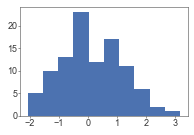

In [18]:
fig = plt.figure(figsize=(3, 2))

# Also works in subplots() command
fig, ax = plt.subplots(figsize=(3, 2))
from scipy.stats import norm
ax.hist(norm.rvs(size=100))
plt.show()

For smaller panels (i.e., 2 x 1 inches), the output in Jupyter can be too small to view when developing the plot. You can use the `dpi` setting to increase the size of the image output in Jupyter

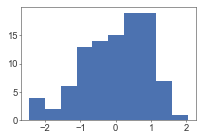

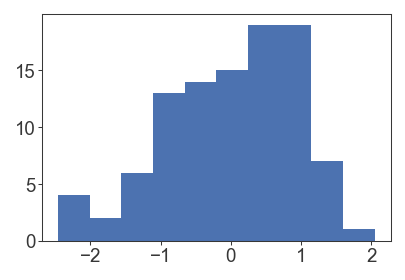

In [21]:
from scipy.stats import norm
x = norm.rvs(size=100)

fig, ax = plt.subplots(figsize=(3, 2), dpi=75)
ax.hist(x)
plt.show()

fig, ax = plt.subplots(figsize=(3, 2), dpi=150)
ax.hist(x)
plt.show()

### Figure padding

I frequently add or remove padding around figures to account for removed axis labels, or maybe large axis labels that jut out a bit more.

You can adjust these via `fig.add_gridspec()` or `plt.subplots_adjust()` with the parameters `left`, `right`, `top`, and `bottom`. Units are in fractions of the figure [0, 1]

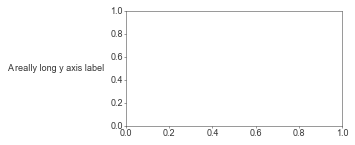

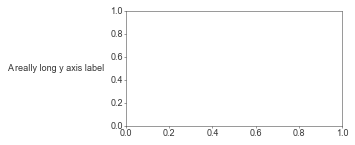

In [58]:
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.2, right=0.7, bottom=0.5, top=0.9)
ax.text(-0.1, 0.5, 'A really long y axis label', transform=ax.transAxes, ha='right', va='center')
plt.show()

fig = plt.figure()
gs = fig.add_gridspec(1, 1, left=0.2, right=0.7, bottom=0.5, top=0.9)
ax = fig.add_subplot(gs[0, 0])
ax.text(-0.1, 0.5, 'A really long y axis label', transform=ax.transAxes, ha='right', va='center')
plt.show()

By default jupyter cuts off whitespace around the plot and extends the plot to cover all grapical elements - so you won't be able to visualize your padding results in the jupyter cell output.

You can solve this by first saving the plot to an image (in a file or in a buffer), and then displaying the raw image

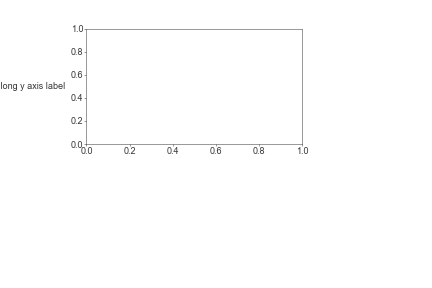

In [61]:
import io
buf = io.BytesIO()

fig = plt.figure()
gs = fig.add_gridspec(1, 1, left=0.2, right=0.7, bottom=0.5, top=0.9)
ax = fig.add_subplot(gs[0, 0])
ax.text(-0.1, 0.5, 'A really long y axis label', transform=ax.transAxes, ha='right', va='center')
# Save to buffer
buf = io.BytesIO()
fig.savefig(buf, format='png')
plt.close() # Suppress output of raw figure object

# Read image from buffer and display
from IPython.display import Image
buf.seek(0)
im = Image(data=buf.read())
buf.close()
im

## Gridspec

It's a few more lines to lay out your plots with `gridspec` instead of `subplots` but it's totally worth it for complex layouts. Plus it also saves you from a `subplots_adjust` call later on.

See: [https://matplotlib.org/stable/gallery/subplots_axes_and_figures/gridspec_multicolumn.html](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/gridspec_multicolumn.html)

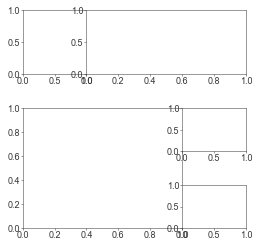

In [66]:
fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(
    3, 3, # rows x cols
    # Cell relative width/heights
    width_ratios=[1, 1.5, 1], # Units are relative to each other
    height_ratios=[150, 100, 100],
    # Padding between cells
    wspace=0.0, # Units are in fractions of the row above/column left? I think?
    hspace=0.7
)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:3])
ax3 = fig.add_subplot(gs[1:3, 0:2])
ax4 = fig.add_subplot(gs[1, 2])
ax5 = fig.add_subplot(gs[2, 2])

plt.show()

For greating a grid of subplots, similar to `subplots()`:

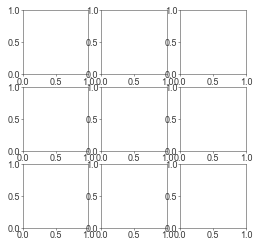

In [27]:
fig = plt.figure(figsize=(4, 4))

nrow = 3
ncol = 3
gs = fig.add_gridspec(nrow, ncol)

for i in range(nrow * ncol):
    row = i // ncol
    col = i % ncol
    ax = fig.add_subplot(gs[row, col])

plt.show()

### Nested Gridspecs

See: [https://matplotlib.org/stable/gallery/subplots_axes_and_figures/gridspec_nested.html](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/gridspec_nested.html)

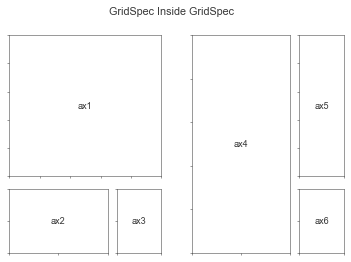

In [68]:
# From: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/gridspec_nested.html

def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)


# gridspec inside gridspec
fig = plt.figure()
gs0 = mpl.gridspec.GridSpec(1, 2, figure=fig)
gs00 = mpl.gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[0])

ax1 = fig.add_subplot(gs00[:-1, :])
ax2 = fig.add_subplot(gs00[-1, :-1])
ax3 = fig.add_subplot(gs00[-1, -1])

# the following syntax does the same as the GridSpecFromSubplotSpec call above:
gs01 = gs0[1].subgridspec(3, 3)

ax4 = fig.add_subplot(gs01[:, :-1])
ax5 = fig.add_subplot(gs01[:-1, -1])
ax6 = fig.add_subplot(gs01[-1, -1])

plt.suptitle("GridSpec Inside GridSpec")
format_axes(fig)

plt.show()

## Scatterplots

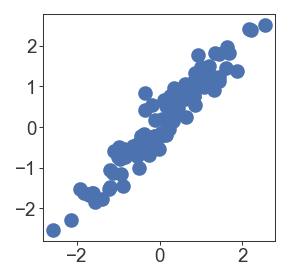

In [75]:
from scipy.stats import norm

x = norm.rvs(size=100)
y = x + norm.rvs(0, 0.3, size=100)

fig = plt.figure(figsize=(2, 2), dpi=150)
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.scatter(x, y)
plt.show()

By default, matplotlib/seaborn also plots an edge around each scatterplot marker that limits the minimum size of points. If you specify `edgecolor='none'`, then you can get correct point sizes

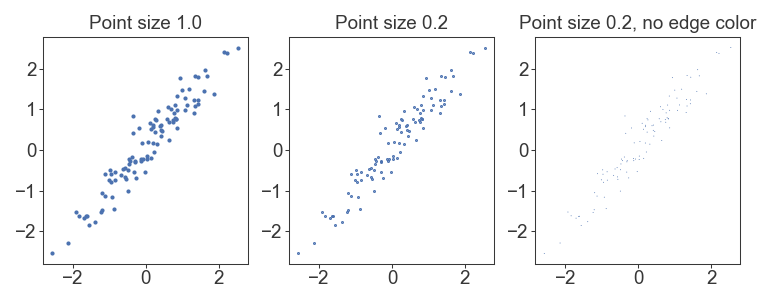

In [84]:
fig = plt.figure(figsize=(6, 2), dpi=150)
gs = fig.add_gridspec(1, 3)
ax = fig.add_subplot(gs[0, 0])
ax.scatter(x, y, s=1)
ax.set_title('Point size 1.0')

ax = fig.add_subplot(gs[0, 1])
ax.scatter(x, y, s=0.2)
ax.set_title('Point size 0.2')

ax = fig.add_subplot(gs[0, 2])
ax.scatter(x, y, s=0.2, edgecolor='none')
ax.set_title('Point size 0.2, no edge color')
plt.show()

### Density scatterplots

For huge datasets of thousands of points, scatterplots will result in points plotting over each other and hiding the underlying distribution of data. For middling datasets you can get away with this by adjusting the alpha of each point, but then it might get difficult to see individual points. It's better to apply a density kernel as a color on top of each point

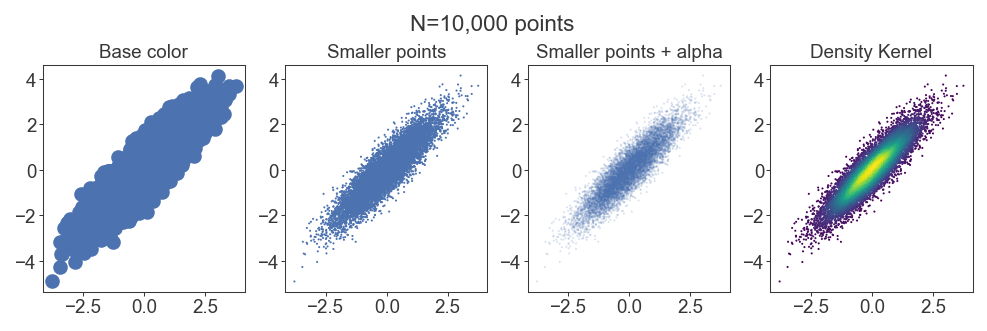

In [154]:
from scipy.stats import norm

x = norm.rvs(size=10_000)
y = x + norm.rvs(0, 0.5, size=10_000)

fig = plt.figure(figsize=(8, 2), dpi=150)
gs = fig.add_gridspec(1, 4)

ax = fig.add_subplot(gs[0, 0])
ax.scatter(x, y)
ax.set_title('Base color')

ax = fig.add_subplot(gs[0, 1])
ax.scatter(x, y, s=1, edgecolor='none')
ax.set_title('Smaller points')

ax = fig.add_subplot(gs[0, 2])
ax.scatter(x, y, s=1, edgecolor='none', alpha=0.2)
ax.set_title('Smaller points + alpha')

from scipy.stats import gaussian_kde
kernel = gaussian_kde(np.vstack([x, y]))
c = kernel(np.vstack([x, y]))

ax = fig.add_subplot(gs[0, 3])
ax.scatter(x, y, s=1, edgecolor='none', c=c, cmap=mpl.cm.viridis)
ax.set_title('Density Kernel')

fig.suptitle('N=10,000 points', y=1.05)
plt.show()

#### Fast subsampled density kernels

For huge datasets, the density kernel takes a really long time to calculate. When developing plots for these huge datasets, I subsample the kernel for faster run times. The result is usually indistinguishable (although for final publication I re-generate with the fully sampled density kernel)

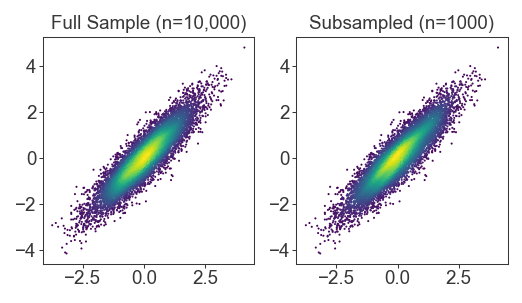

In [151]:
from scipy.stats import norm

x = pd.Series(norm.rvs(size=10_000)) # Use pandas Series for the sample function
y = x + norm.rvs(0, 0.5, size=10_000)

fig = plt.figure(figsize=(4, 2), dpi=150)
gs = fig.add_gridspec(1, 2)

from scipy.stats import gaussian_kde
kernel = gaussian_kde(np.vstack([x, y]))
c = kernel(np.vstack([x, y]))

ax = fig.add_subplot(gs[0, 0])
ax.scatter(x, y, s=1.0, edgecolor='none', c=c, cmap=mpl.cm.viridis)
ax.set_title('Full Sample (n=10,000)')

# Kernel subsampling
# Maintain random state between x and y, otherwise we'll pull different samples
# from each vector
kernel = gaussian_kde(np.vstack([
    x.sample(n=1000, random_state=1), 
    y.sample(n=1000, random_state=1)
]))
c = kernel(np.vstack([x, y]))

ax = fig.add_subplot(gs[0, 1])
ax.scatter(x, y, s=1.0, edgecolor='none', c=c, cmap=mpl.cm.viridis)
ax.set_title('Subsampled (n=1000)')

plt.show()

#### Stored density kernels

For full density kernels, you could also store the color vectors in a list/dictionary in a prior cell, so that you can iterate on your plot without regenerating the kernel and its estimates every run

In [152]:
n_datasets = 4

xs = []
ys = []
for i in range(n_datasets):
    xs.append(norm.rvs(size=10_000)) # Use pandas Series for the sample function
    ys.append(xs[i] + norm.rvs(0, (i+1) / 4, size=10_000))

colorvecs = []
for i in range(n_datasets):
    x = xs[i]
    y = ys[i]
    kernel = gaussian_kde(np.vstack([x, y]))
    colorvecs.append(kernel(np.vstack([x, y])))


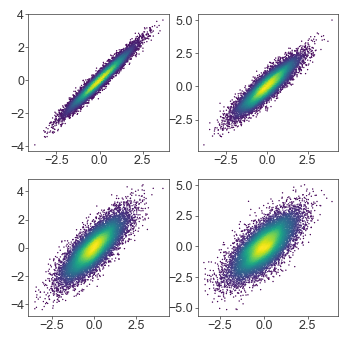

In [153]:
fig = plt.figure(figsize=(4, 4), dpi=100)
gs = fig.add_gridspec(2, 2)

for i in range(n_datasets):
    ax = fig.add_subplot(gs[i // 2, i % 2])
    x = xs[i]
    y = ys[i]
    c = colorvecs[i]
    ax.scatter(x, y, c=c, cmap=mpl.cm.viridis, s=1.0, edgecolor='none')

plt.show()

### Scatterplot rasterization

If moving large scatterplot figures into another program (i.e., Illustrator), saving as vector graphics (SVG, PDF) will make every point an object and make the resulting file impossible to open/edit. Saving the entire plot as an image (JPEG/PNG) is also undesirable since we would want the line/text elements (axis labels, etc) to remain as vector graphics.

The solution is to pass `rasterized=True` into the `scatter()` call, so that *only the scatterplot points* are rasterized, while the rest of the plot stays vectorized.

At small figure sizes/low DPIs, the rasterization may be too apparent (too low resolution). You can solve this by bumping up the DPI of the figure

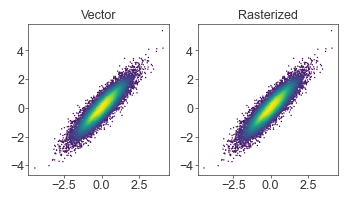

In [149]:
x = norm.rvs(size=10_000)
y = x + norm.rvs(0, 0.5, size=10_000)

fig = plt.figure(figsize=(4, 2), dpi=100)
gs = fig.add_gridspec(1, 2)

kernel = gaussian_kde(np.vstack([x, y]))
c = kernel(np.vstack([x, y]))

ax = fig.add_subplot(gs[0, 0])
ax.scatter(x, y, s=1, c=c, cmap=mpl.cm.viridis, edgecolor='none')
ax.set_title('Vector')

ax = fig.add_subplot(gs[0, 1])
ax.scatter(x, y, s=1, c=c, cmap=mpl.cm.viridis, rasterized=True, edgecolor='none')
ax.set_title('Rasterized')

plt.show()

## Text annotation

Placing text annotations on plots can be tricky if using the same coordinate system as the data - different scales will require a lot of custom code to tweak the exact location of each text label.

Instead, use `transform=ax.transAxes` to place text relative to the *axis box*, instead of in the data coordinate system

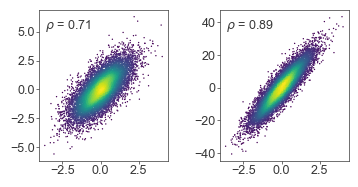

In [240]:
x = norm.rvs(size=10_000, random_state=1)
y1 = x + norm.rvs(size=10_000, random_state=2)
y2 = 10 * (x + norm.rvs(size=10_000, scale=0.5, random_state=3))

fig = plt.figure(figsize=(4, 2), dpi=100)
gs = fig.add_gridspec(1, 2, wspace=0.4)

ax = fig.add_subplot(gs[0, 0])
kernel = gaussian_kde(np.vstack([x, y1]))
c = kernel(np.vstack([x, y1]))

ax.scatter(x, y1, c=c, cmap=mpl.cm.viridis, s=1.0, edgecolor='none')
ax.text(0.05, 0.95, r'$\rho$ = {:.2f}'.format(np.corrcoef(x, y1)[0, 1]), 
    transform=ax.transAxes, ha='left', va='top')

ax = fig.add_subplot(gs[0, 1])
kernel = gaussian_kde(np.vstack([x, y2]))
c = kernel(np.vstack([x, y2]))

ax.scatter(x, y2, c=c, cmap=mpl.cm.viridis, s=1.0, edgecolor='none')
ax.text(0.05, 0.95, r'$\rho$ = {:.2f}'.format(np.corrcoef(x, y2)[0, 1]), 
    transform=ax.transAxes, ha='left', va='top')


plt.show()


### Blended transforms

Guide: [https://matplotlib.org/stable/tutorials/advanced/transforms_tutorial.html#blended-transformations](https://matplotlib.org/stable/tutorials/advanced/transforms_tutorial.html#blended-transformations)

Sometimes it's useful to have one coordinate relative to the axis, and another relative to the data. For example, annotating a significance cutoff on a plot:

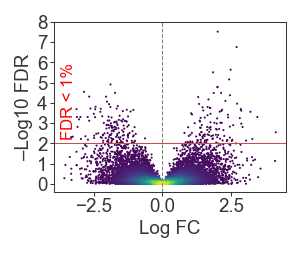

In [231]:
from scipy.stats import expon

x = norm.rvs(size=10_000, random_state=2)
y = np.abs(x) * expon.rvs(scale=0.5, size=10_000, random_state=2)

kernel = gaussian_kde(np.vstack([x, y]))
c = kernel(np.vstack([x, y]))

fig = plt.figure(figsize=(2, 1.5), dpi=150)
gs = fig.add_gridspec(1, 1, wspace=0.4)

ax = fig.add_subplot(gs[0, 0])
ax.scatter(x, y, s=1.0, c=c, cmap=mpl.cm.viridis, edgecolor='none')
ax.axhline(2, color='r', linewidth=0.5)
ax.text(0.03, 2.2, 'FDR < 1%', color='red', fontsize=8,
    transform=mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData),
    rotation=90, ha='left', va='bottom'
)
ax.axvline(0, color='gray', linewidth=0.5, linestyle='--')
ax.set_yticks(np.arange(0, 9))
ax.set_xlabel('Log FC')
ax.set_ylabel('–Log10 FDR')

plt.show()

### Point annotation

adjustText is a great package (inspired from `ggrepel`) to annotate individual points: [https://github.com/Phlya/adjustText](https://github.com/Phlya/adjustText)

- adjustText guide: [https://github.com/Phlya/adjustText/wiki](https://github.com/Phlya/adjustText/wiki)
- adjustText API: [https://adjusttext.readthedocs.io/en/latest/](https://adjusttext.readthedocs.io/en/latest/)
- `annotate` API: [https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.annotate.html](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.annotate.html)
- Arrow parameters: [https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.FancyArrowPatch.html#matplotlib.patches.FancyArrowPatch](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.FancyArrowPatch.html#matplotlib.patches.FancyArrowPatch)

/Users/chena/miniconda3/lib/python3.7/site-packages/matplotlib/transforms.py:659: RuntimeWarning: invalid value encountered in double_scalars
  deltaw = (sw * width - width) / 2.0
/Users/chena/miniconda3/lib/python3.7/site-packages/matplotlib/transforms.py:660: RuntimeWarning: invalid value encountered in double_scalars
  deltah = (sh * height - height) / 2.0


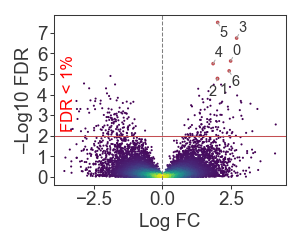

In [287]:
from scipy.stats import expon
from adjustText import adjust_text

x = norm.rvs(size=10_000, random_state=2)
y = np.abs(x) * expon.rvs(scale=0.5, size=10_000, random_state=2)

kernel = gaussian_kde(np.vstack([x, y]))
c = kernel(np.vstack([x, y]))

fig = plt.figure(figsize=(2, 1.5), dpi=150)
gs = fig.add_gridspec(1, 1, wspace=0.4)

ax = fig.add_subplot(gs[0, 0])
scatter = ax.scatter(x, y, s=1.0, c=c, cmap=mpl.cm.viridis, edgecolor='none')
ax.axhline(2, color='r', linewidth=0.5)
ax.text(0.03, 2.2, 'FDR < 1%', color='red', fontsize=8,
    transform=mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData),
    rotation=90, ha='left', va='bottom'
)
ax.axvline(0, color='gray', linewidth=0.5, linestyle='--')
ax.set_yticks(np.arange(0, 9))
ax.set_xlabel('Log FC')
ax.set_ylabel('–Log10 FDR')

sig = (x > 1.8) & (y > 4.5)
texts = [
    plt.text(_x, _y, str(i), ha='center', va='center', fontsize=7) 
    for i, (_x, _y) in enumerate(zip(x[sig], y[sig]))
]
adjust_text(texts, add_objects=[scatter], expand_points=(1.5, 1.5),
arrowprops=dict(arrowstyle='-', color='#AAA', mutation_scale=3, linewidth=0.5))

# Make significant points bigger
ax.scatter(x[sig], y[sig], s=3, color='r', edgecolor='none')

plt.show()

## Grids

IMO grids are distracting and should only be used when comparing values is crucial to the message of the figure.

For example, grids in scatterplots are generally not useful. For plots like volcano plots where it's necessary to visualize a significance cutoff (e.g., FDR < 1%), it's more efficient to draw just the cutoff and still forgo the grid.

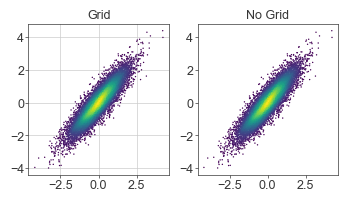

In [156]:
x = norm.rvs(size=10_000)
y = x + norm.rvs(0, 0.5, size=10_000)

fig = plt.figure(figsize=(4, 2), dpi=100)
gs = fig.add_gridspec(1, 2)

kernel = gaussian_kde(np.vstack([x, y]))
c = kernel(np.vstack([x, y]))

ax = fig.add_subplot(gs[0, 0])
ax.scatter(x, y, s=1, c=c, cmap=mpl.cm.viridis, edgecolor='none')
ax.grid(linewidth=0.5)
ax.set_title('Grid')

ax = fig.add_subplot(gs[0, 1])
ax.scatter(x, y, s=1, c=c, cmap=mpl.cm.viridis, rasterized=True, edgecolor='none')
ax.set_title('No Grid')

plt.show()

Of course the use of the grid is stylistic and also dependent on the message. Does it matter that the reader can use the grid to know that the top points are between 10e-6 and 10e-8? Or is it sufficient to just communicate that those points are *way* above the other hits and our significance cutoff?

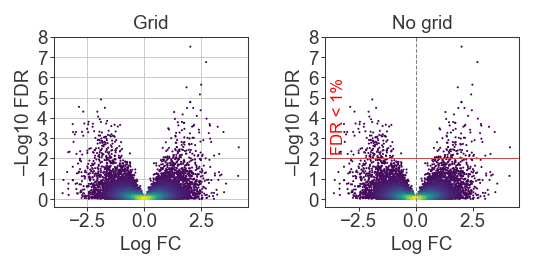

In [200]:
from scipy.stats import expon

x = norm.rvs(size=10_000, random_state=2)
y = np.abs(x) * expon.rvs(scale=0.5, size=10_000, random_state=2)

kernel = gaussian_kde(np.vstack([x, y]))
c = kernel(np.vstack([x, y]))

fig = plt.figure(figsize=(4, 1.5), dpi=150)
gs = fig.add_gridspec(1, 2, wspace=0.4)

ax = fig.add_subplot(gs[0, 0])
ax.scatter(x, y, s=1.0, c=c, cmap=mpl.cm.viridis, edgecolor='none')
ax.set_yticks(np.arange(0, 9))
ax.grid(linewidth=0.5)
ax.set_xlabel('Log FC')
ax.set_ylabel('–Log10 FDR')
ax.set_title('Grid')

ax = fig.add_subplot(gs[0, 1])
ax.scatter(x, y, s=1.0, c=c, cmap=mpl.cm.viridis, edgecolor='none')
ax.axhline(2, color='r', linewidth=0.5)
ax.text(0.03, 2.2, 'FDR < 1%', color='red', fontsize=8,
    transform=mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData),
    rotation=90, ha='left', va='bottom'
)
ax.axvline(0, color='gray', linewidth=0.5, linestyle='--')
ax.set_yticks(np.arange(0, 9))
ax.set_xlabel('Log FC')
ax.set_ylabel('–Log10 FDR')
ax.set_title('No grid')

plt.show()

For this example, it probably matters more where exactly each bar lies. We're comparing a two values, and the scale is not as stretched out as the volcano plot so it matters more to know the exact location between our y-ticks. In this case the grid is helpful

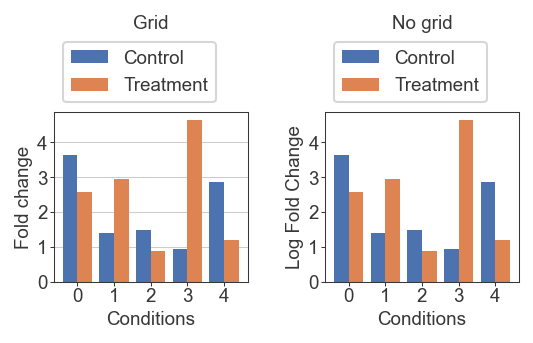

In [228]:
x = np.arange(0, 5)
y1 = norm.rvs(loc=2, scale=1, size=5, random_state=1)
y2 = norm.rvs(loc=3, scale=1, size=5, random_state=2)
bar_width = 0.4

fig = plt.figure(figsize=(4, 1.5), dpi=150)
gs = fig.add_gridspec(1, 2, wspace=0.4)

ax = fig.add_subplot(gs[0, 0])
ax.bar(x - (bar_width/2) , y1, width=bar_width, label='Control')
ax.bar(x + (bar_width/2) , y2, width=bar_width, label='Treatment')
ax.set_xticks(x)
ax.set_yticks(np.arange(0, 5))
ax.set_xlabel('Conditions')
ax.set_ylabel('Fold change')
ax.set_title('Grid', pad=40)
ax.grid(axis='y', linewidth=0.5)
ax.legend(loc='lower left', bbox_to_anchor=(0,1))

ax = fig.add_subplot(gs[0, 1])
ax.bar(x - (bar_width/2) , y1, width=bar_width, label='Control')
ax.bar(x + (bar_width/2) , y2, width=bar_width, label='Treatment')
ax.set_xticks(x)
ax.set_yticks(np.arange(0, 5))
ax.set_xlabel('Conditions')
ax.set_ylabel('Log Fold Change')
ax.set_title('No grid', pad=40)
ax.legend(loc='lower left', bbox_to_anchor=(0,1))

plt.show()

## Colorbars

I prefer to manually allocate space for colorbars instead of trusting matplotlib to create a sensible placement. This also gives you more direct control over the spacing and the axes (instead of having to rely on proxy functions on the created colorbar object).

Instead of tuning `width_ratio` on `subplot()` or `gridspec()`, I create separate gridspecs for the plot and the colorbar, which let's me tune the spacing with the padding keyword arguments

I first test this out by creating empty axes to see where things will land:

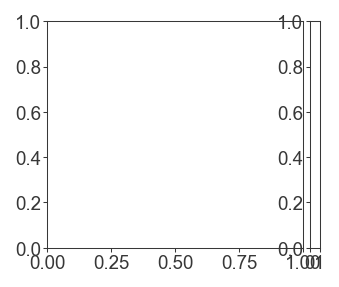

In [336]:
x = norm.rvs(size=10_000)
y = x + norm.rvs(0, 0.5, size=10_000)

fig = plt.figure(figsize=(2.2, 2), dpi=150)
gs = fig.add_gridspec(1, 1, right=0.9)

# kernel = gaussian_kde(np.vstack([x, y]))
# c = kernel(np.vstack([x, y]))

ax = fig.add_subplot(gs[0, 0])
# ax.scatter(x, y, s=1, c=c, cmap=mpl.cm.viridis, edgecolor='none')

# Colorbar grid and axes
gs_cbar = fig.add_gridspec(1, 1, left=0.92, right=0.95)
ax = fig.add_subplot(gs_cbar[0, 0])

plt.show()

Then I fill in, and pass the scatterplot object to the colorbar as a mappable.

I try to avoid sideways text wherever possible, and to instead place the colorbar label on top and offset of the colorbar for easier reading

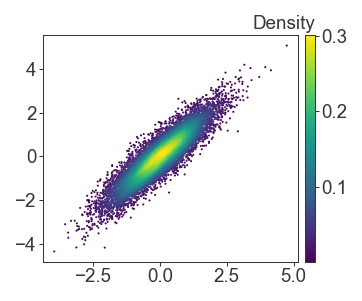

In [339]:
x = norm.rvs(size=10_000)
y = x + norm.rvs(0, 0.5, size=10_000)

fig = plt.figure(figsize=(2.2, 2), dpi=150)
gs = fig.add_gridspec(1, 1, right=0.9)

kernel = gaussian_kde(np.vstack([x, y]))
c = kernel(np.vstack([x, y]))

ax = fig.add_subplot(gs[0, 0])
scatter = ax.scatter(x, y, s=1, c=c, cmap=mpl.cm.viridis, edgecolor='none')

# Colorbar grid and axes
gs_cbar = fig.add_gridspec(1, 1, left=0.92, right=0.95)
ax = fig.add_subplot(gs_cbar[0, 0])
fig.colorbar(scatter, cax=ax)
ax.text(1, 1.01, 'Density', transform=ax.transAxes, ha='right', va='bottom')

plt.show()

If you have multiple panels, or multiple `mappables` to pass to colorbar, it's simple to define the mapping yourself. Just remember that if you set `vmin` and `vmax` manually on the colorbar, to also enforce the same limits on your other plots as well.

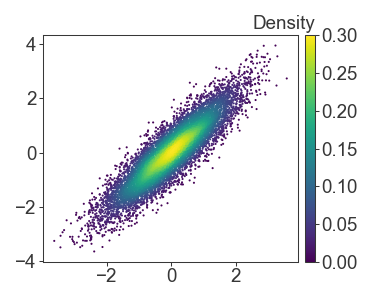

In [341]:
x = norm.rvs(size=10_000)
y = x + norm.rvs(0, 0.5, size=10_000)

fig = plt.figure(figsize=(2.2, 2), dpi=150)
gs = fig.add_gridspec(1, 1, right=0.9)

kernel = gaussian_kde(np.vstack([x, y]))
c = kernel(np.vstack([x, y]))

ax = fig.add_subplot(gs[0, 0])
scatter = ax.scatter(x, y, s=1, c=c, vmin=0, vmax=0.3, cmap=mpl.cm.viridis, edgecolor='none')

# Colorbar grid and axes
gs_cbar = fig.add_gridspec(1, 1, left=0.92, right=0.95)
ax = fig.add_subplot(gs_cbar[0, 0])
fig.colorbar(
    mpl.cm.ScalarMappable(
        norm=mpl.colors.Normalize(vmin=0, vmax=0.3), 
        cmap=mpl.cm.viridis
    ), 
    cax=ax
)
ax.text(1, 1.01, 'Density', transform=ax.transAxes, ha='right', va='bottom')

plt.show()